# Compare real CELEX (and others) to artificial lexicons

Using the code here (https://github.com/SbllDtrch/NullLexicons) to generate artificial lexicons based on real phonotactic properties of a language. We can then compare distributional properties of the real lexicon to these artificial lexicons.

In [1]:
import src.utils as utils
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as sm

from tqdm import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

## English

First we investigate the English lexicon. We compare lemmas from CELEX to a number of artificially-generated lexicons, matched for the same distribution of syllable lengths.

### Real lexicon

In [3]:
df_celex_og = pd.read_csv("data/processed/english/english_all_reals.csv")
print(len(df_celex_og))

52438


In [4]:
df_celex_processed = pd.read_csv("data/processed/english/english_lemmas_processed.csv")
len(df_celex_processed)

35107

In [5]:
df_celex_og.head(5)

,Unnamed: 0,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,num_phones,num_sylls_est,log_prob,surprisal
0,0,a,4.36,1,1,ART,1,1,1,-4.543025,4.543025
1,1,a,4.37,1,1,N,1,1,1,-4.543025,4.543025
2,2,a,2.67,0,1,NaN,1,1,1,-4.543025,4.543025
3,3,A,4.37,0,1,NaN,1,1,1,-4.543025,4.543025
4,4,AA,0.48,1,11,N,2,2,2,-4.726224,4.726224


In [6]:
REAL_HOMOPHONE_PERCENTAGE = len(df_celex_processed[df_celex_processed['num_homophones']>0]) / len(df_celex_processed)
REAL_HOMOPHONE_PERCENTAGE

0.1564360383969009

In [7]:
df_celex_processed['num_homophones'].mean()

0.19312387842880338

### Compare to null lexicon

In [8]:
# NUM_ARTIFICIAL = 10
NUM_ARTIFICIAL = 10

In [9]:
df_english_with_sims = pd.read_csv("data/processed/english/english_artificial_10_matched_on_sylls.csv")


In [10]:
df_english_with_sims['lexicon'] = df_english_with_sims['lexicon'].apply(lambda x: str(x))

In [11]:
df_english_with_sims.head(5)

,Unnamed: 0,lexicon,num_phones,num_sylls_est,prob,surprisal,word
0,0,0,6,2,-6.862922,6.862922,lItm6T
1,1,0,8,3,-5.093740,5.093740,k{pIt@nt
2,2,0,7,3,-4.923106,4.923106,{ntIdlI
3,3,0,9,3,-6.755240,6.755240,Vnwildw3k
4,4,0,6,2,-6.177147,6.177147,kr$lIk


#### Phonotactics

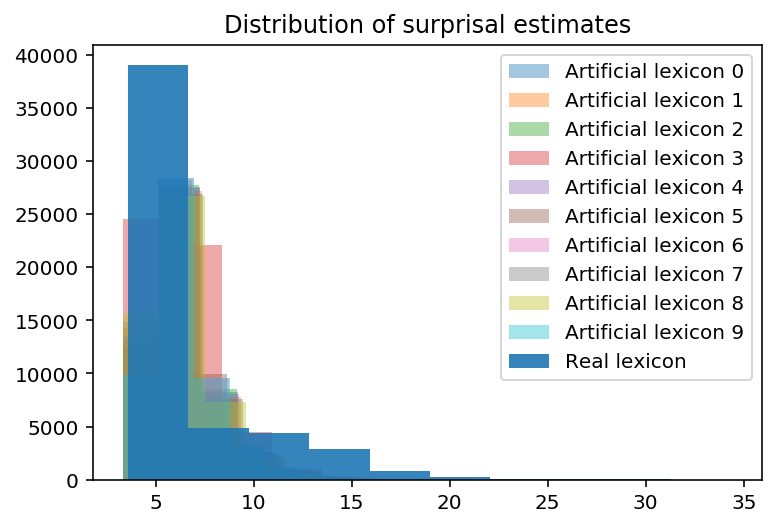

In [12]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_english_with_sims[df_english_with_sims['lexicon']==str(i)]
    # df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
    #                                                  phon_column="word", word_column="word")
    plt.hist(df_tmp['surprisal'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))

plt.hist(df_celex_og['surprisal'], 
         alpha = .9, label = "Real lexicon".format(x=i))
plt.title("Distribution of surprisal estimates")
plt.legend()

In [13]:
import seaborn as sns

/Users/seantrott/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Distribution of surprisal estimates')

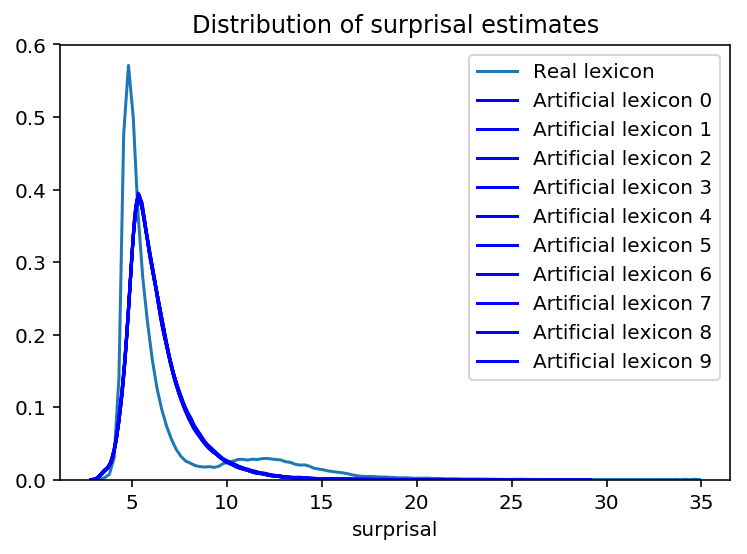

In [14]:
sns.distplot(df_celex_og['surprisal'], hist=False, label = "Real lexicon")

for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_english_with_sims[df_english_with_sims['lexicon']==str(i)]
    # df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
    #                                                  phon_column="word", word_column="word")
    sns.distplot(df_tmp['surprisal'], color = "blue", hist=False, label = "Artificial lexicon {x}".format(x=i))

plt.title("Distribution of surprisal estimates")


#### Lengths

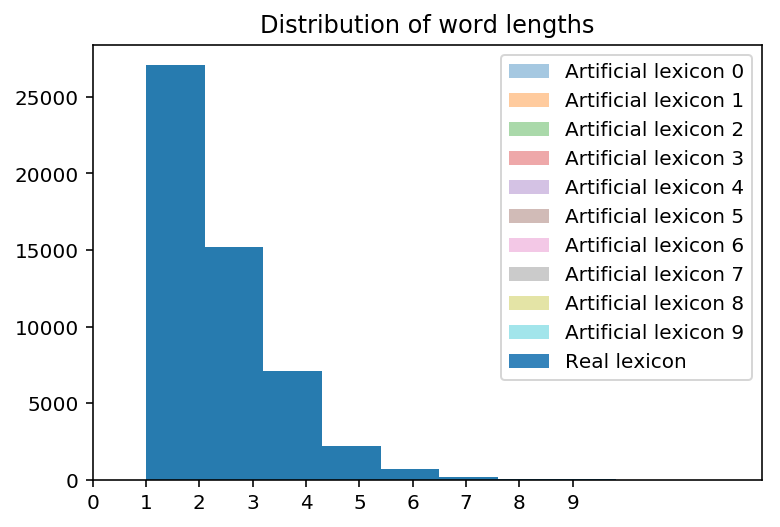

In [19]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_english_with_sims[df_english_with_sims['lexicon']==str(i)]
    plt.hist(df_tmp['num_sylls_est'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))

# plt.hist(df_english_with_sims[df_english_with_sims['lexicon']=="real"]['length'], 
#          alpha = .6, label = "Real lexicon".format(x=i))

plt.hist(df_celex_og['num_sylls_est'], 
          alpha = .9, label = "Real lexicon".format(x=i))
plt.title("Distribution of word lengths")
plt.xticks(range(0, 10))
plt.legend()

In [15]:
from collections import Counter
Counter(df_celex_og['num_sylls_est'])

Counter({1: 7855,
         2: 19198,
         3: 15165,
         4: 7124,
         5: 2223,
         6: 670,
         7: 165,
         8: 25,
         10: 5,
         9: 7,
         12: 1})

## Homophones

### Comparing percentage, mean, and max of homophones

In [16]:
processed_artificials = []
homophone_percentages = []
mean_homophones, max_homophones = [], []
for i in tqdm(range(NUM_ARTIFICIAL)):
    
    df_tmp = df_english_with_sims[df_english_with_sims['lexicon']==str(i)]
    
    df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                      phon_column="word", word_column="word")
    
    homophone_percentages.append(len(df_tmp_processed[df_tmp_processed['num_homophones']>0]) / len(df_tmp_processed))

    mean_homophones.append(df_tmp_processed['num_homophones'].mean())
    max_homophones.append(df_tmp_processed['num_homophones'].max())

    processed_artificials.append(df_tmp_processed)


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


No handles with labels found to put in legend.


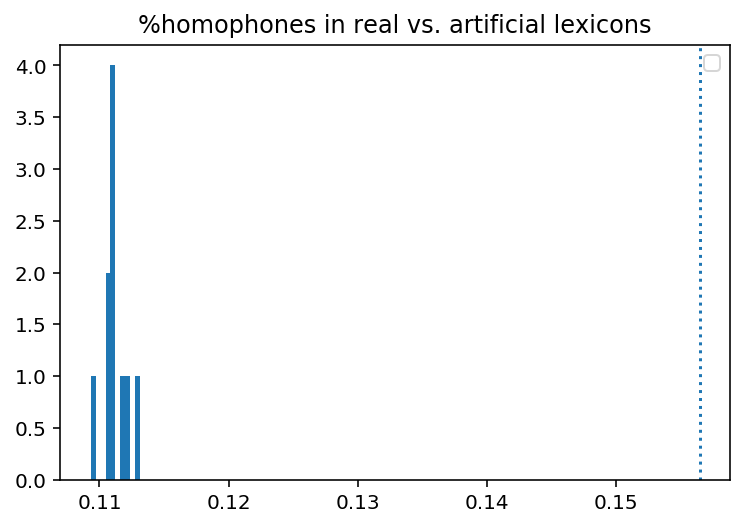

In [17]:
plt.hist(homophone_percentages)
plt.title("%homophones in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=REAL_HOMOPHONE_PERCENTAGE, linestyle="dotted")


No handles with labels found to put in legend.


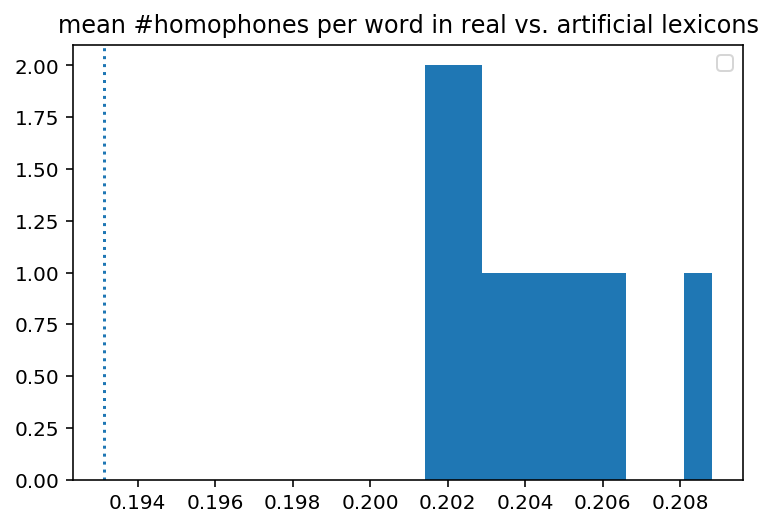

In [18]:
plt.hist(mean_homophones)
plt.title("mean #homophones per word in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=df_celex_processed['num_homophones'].mean(), linestyle="dotted")


No handles with labels found to put in legend.


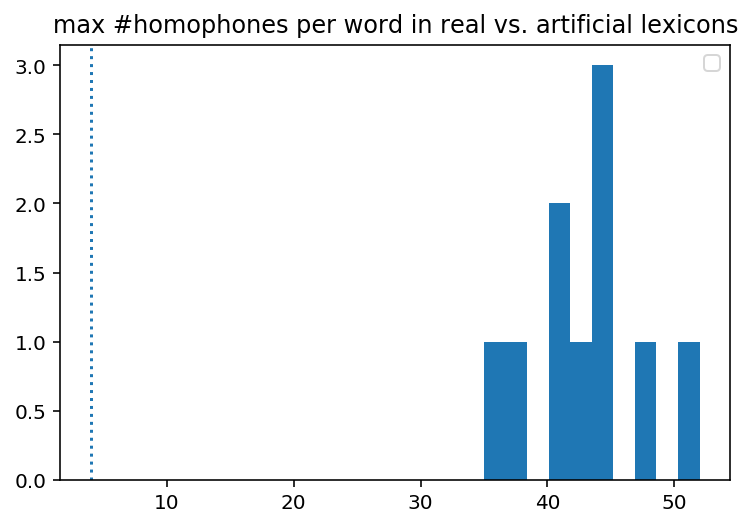

In [50]:
plt.hist(max_homophones)
plt.title("max #homophones per word in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=df_celex_processed['num_homophones'].max(), linestyle="dotted")


##### By syllables

In [20]:
df_agg_real = utils.agg_homophones_by_syllable(df_celex_processed, 
                                          syl_column='num_sylls_est', 
                                          homophone_column='num_homophones')

/Users/seantrott/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/seantrott/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


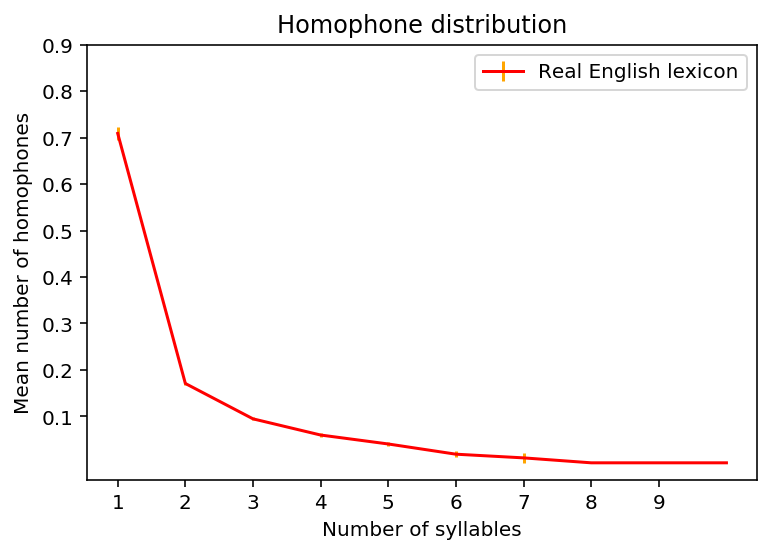

In [21]:
### First plot real
plt.title("Homophone distribution")
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")
plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real English lexicon")
plt.xticks(list(range(1, 10)))
plt.yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9])
plt.legend(loc='upper right')

In [22]:
artificials = []
for df_tmp_processed in tqdm(processed_artificials):
    
    df_agg_art = utils.agg_homophones_by_syllable(df_tmp_processed, 
                                              syl_column='num_sylls_est', 
                                              homophone_column='num_homophones')
    artificials.append(df_agg_art)

df_artificials = pd.concat(artificials)

100%|██████████| 10/10 [00:01<00:00,  9.30it/s]


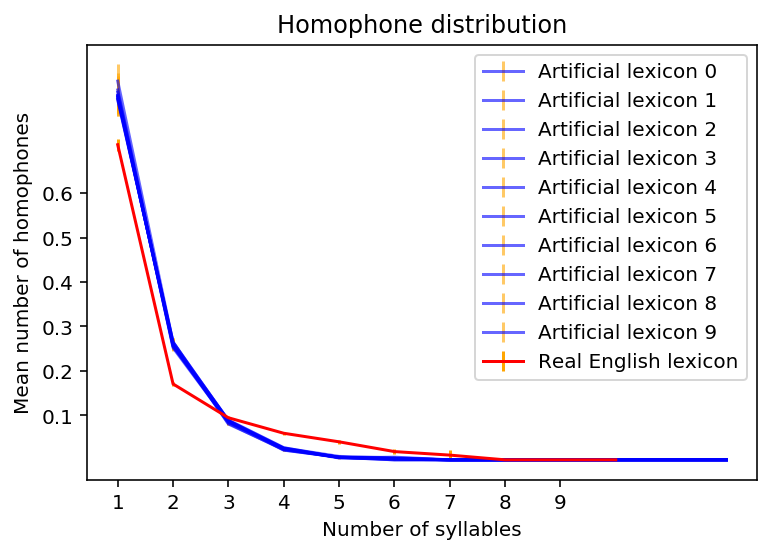

In [23]:
plt.title("Homophone distribution")
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")

for i, df in enumerate(artificials):
    
    plt.errorbar(df['num_sylls'], df['mean_homophones'], alpha = .6,
                        yerr=df['sem_homophones'], color = "blue", ecolor="orange",
                label = "Artificial lexicon {x}".format(x=i))

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real English lexicon")
plt.xticks(list(range(1, 10)))
plt.yticks([.1, .2, .3, .4, .5, .6])
plt.legend(loc='upper right')

#### Statistics 

Interestingly, whether the **real slope** falls to the left or right of the simulated distribution appears to depend on whether **surprisal** is included as a covariate. If it is, then the **real slope** surpasses the **simulated lexicons**––e.g. above "chance". But if it's not, then it's weaker than "chance".

In [24]:
slope_coefs_english = []
surprisal_coefs_english = []
for df_tmp_processed in tqdm(processed_artificials):    
    result = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_tmp_processed).fit(disp=0)
    slope_coefs_english.append(result.params['num_sylls_est'])
    surprisal_coefs_english.append(result.params['surprisal'])

100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


In [25]:
result_real = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_celex_processed).fit(disp=0)
real_slope = result_real.params['num_sylls_est']
surprisal_slope = result_real.params['surprisal']

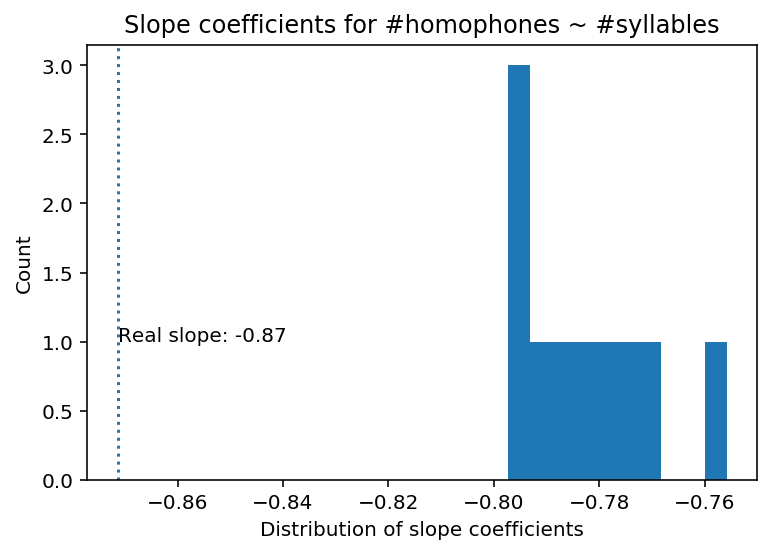

In [26]:
plt.hist(slope_coefs_english)
plt.axvline(x=real_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(real_slope, 2)),x=real_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ #syllables")
# plt.legend(loc='upper right')
plt.show()

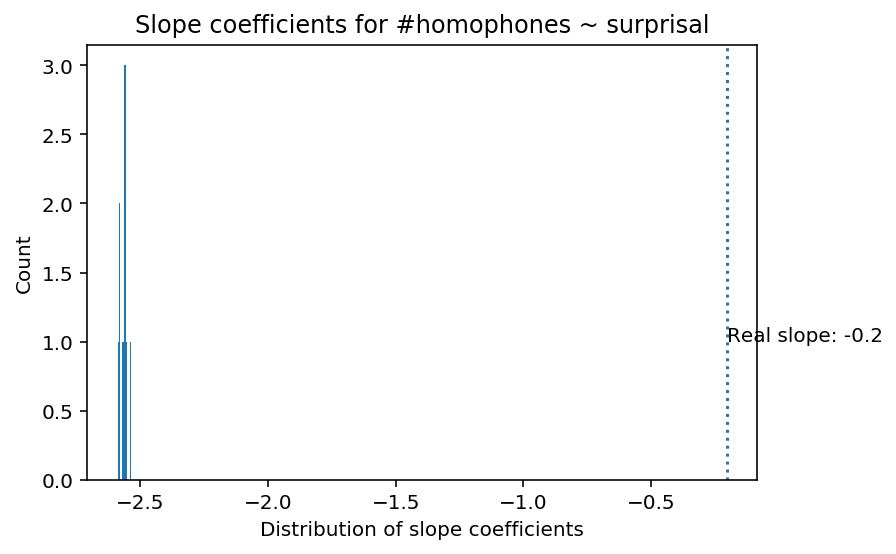

In [27]:
plt.hist(surprisal_coefs_english)
plt.axvline(x=surprisal_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(surprisal_slope, 2)),x=surprisal_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ surprisal")
# plt.legend(loc='upper right')
plt.show()

## German

### Real lexicon

In [28]:
df_celex_og = pd.read_csv("data/processed/german/german_all_reals.csv")

In [29]:
len(df_celex_og)

51719

In [30]:
df_celex_processed = pd.read_csv("data/processed/german/german_lemmas_processed.csv")
df_celex_processed.head(5)

,Unnamed: 0,index,Word,CompCnt,PhonDISC,SylCnt,num_phones,num_sylls_est,remove,num_homophones,log_prob,surprisal
0,0,0,A,1,a,1,1,1,False,1,-4.700550,4.700550
1,1,1,Ae,1,),1,1,1,False,0,-4.708451,4.708451
2,2,2,aalen,1,al@n,2,4,2,False,0,-4.999407,4.999407
3,3,3,Aal,1,al,1,2,1,False,0,-4.736787,4.736787
4,4,4,aalglatt,2,algl&t,2,6,2,False,0,-6.063007,6.063007


In [31]:
len(df_celex_processed)

50474

In [32]:
REAL_GERMAN_PERCENTAGE = round(len(df_celex_processed[df_celex_processed['num_homophones']>0]) / len(df_celex_processed),
                               2)
REAL_GERMAN_PERCENTAGE

0.02

In [33]:
df_celex_processed['num_homophones'].mean()

0.024646352577564687

### Compare to null lexicon

In [34]:
# NUM_ARTIFICIAL = 10
NUM_ARTIFICIAL = 10

In [35]:
df_german_artificials = pd.read_csv("data/processed/german/german_artificial_10_matched_on_sylls.csv")

In [36]:
df_german_artificials['lexicon'] = df_german_artificials['lexicon'].apply(lambda x: str(x))

In [37]:
df_german_artificials.head(5)

,Unnamed: 0,lexicon,num_phones,num_sylls_est,prob,surprisal,word
0,0,0,7,2,-6.939665,6.939665,k<lBf@n
1,1,0,7,3,-6.100064,6.100064,kOt@lIx
2,2,0,11,4,-8.701623,8.701623,b@S&t@nrExt
3,3,0,4,2,-4.558483,4.558483,demi
4,4,0,8,3,-5.402361,5.402361,WnStX@rn


In [38]:
len(df_german_artificials)

517190

#### Phonotactics

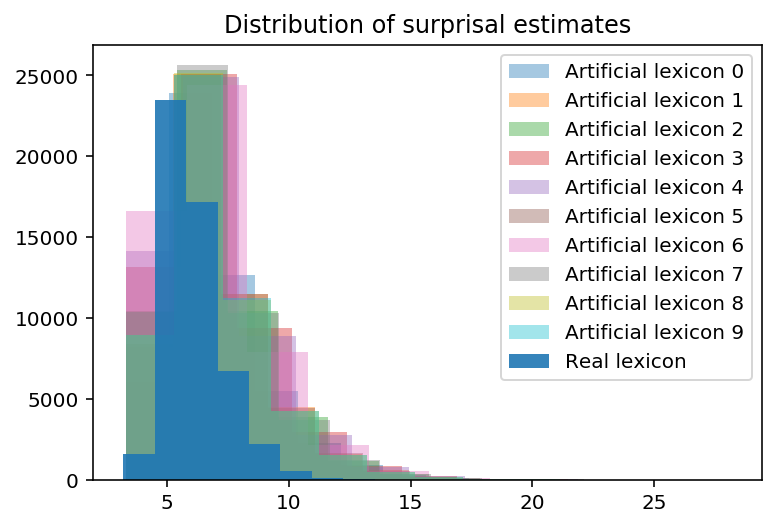

In [39]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_german_artificials[df_german_artificials['lexicon']==str(i)]
    # df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
    #                                                  phon_column="word", word_column="word")
    plt.hist(df_tmp['surprisal'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))

plt.hist(df_celex_og['surprisal'], 
         alpha = .9, label = "Real lexicon".format(x=i))
plt.title("Distribution of surprisal estimates")
plt.legend()

#### Length

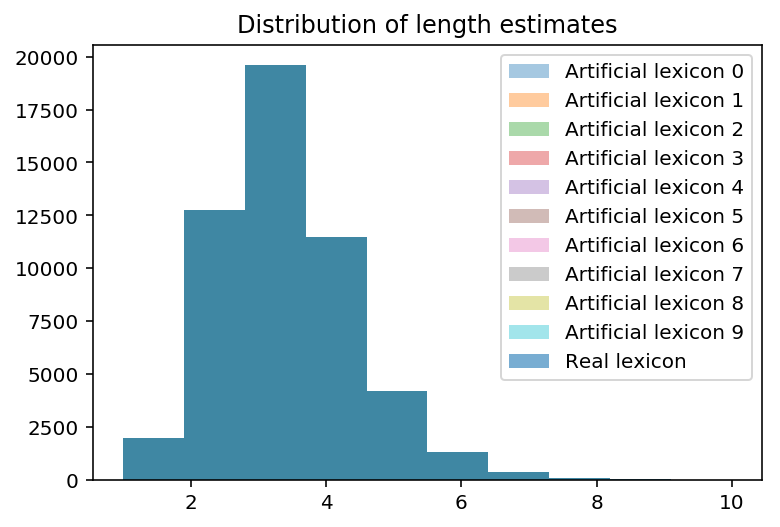

In [40]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_german_artificials[df_german_artificials['lexicon']==str(i)]
    # df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
    #                                                  phon_column="word", word_column="word")
    plt.hist(df_tmp['num_sylls_est'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))

plt.hist(df_celex_og['num_sylls_est'], 
         alpha = .6, label = "Real lexicon".format(x=i))
plt.title("Distribution of length estimates")
plt.legend()

## Homophones

### Comparing percentage, mean, and max of homophones

In [41]:
processed_artificials = []
homophone_percentages = []
mean_homophones, max_homophones = [], []
for i in tqdm(range(NUM_ARTIFICIAL)):
    
    df_tmp = df_german_artificials[df_german_artificials['lexicon']==str(i)]
    
    df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                      phon_column="word", word_column="word")
    
    homophone_percentages.append(len(df_tmp_processed[df_tmp_processed['num_homophones']>0]) / len(df_tmp_processed))

    mean_homophones.append(df_tmp_processed['num_homophones'].mean())
    max_homophones.append(df_tmp_processed['num_homophones'].max())

    processed_artificials.append(df_tmp_processed)


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


No handles with labels found to put in legend.


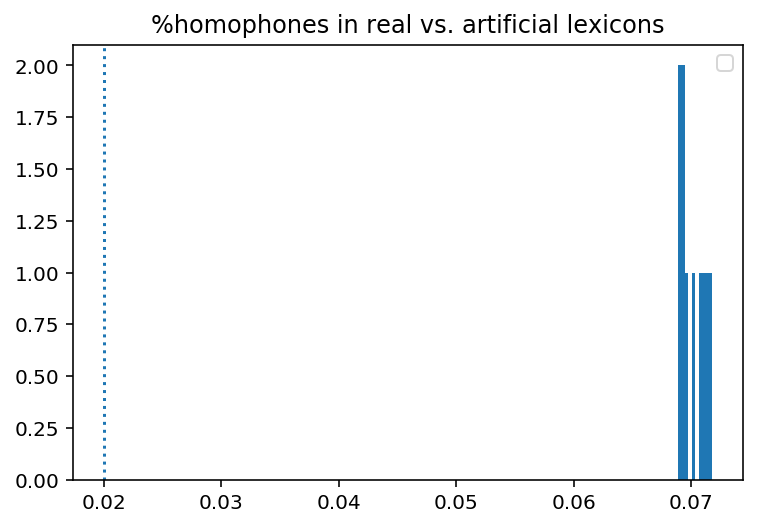

In [42]:
plt.hist(homophone_percentages)
plt.title("%homophones in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=REAL_GERMAN_PERCENTAGE, linestyle="dotted")


No handles with labels found to put in legend.


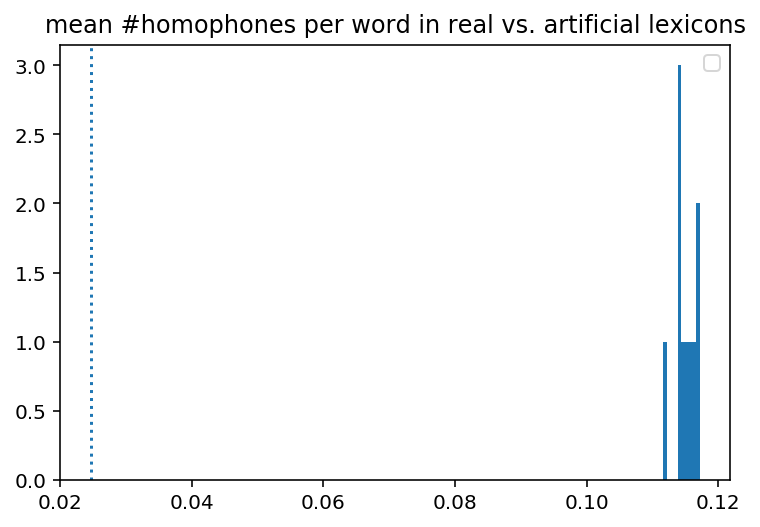

In [43]:
plt.hist(mean_homophones)
plt.title("mean #homophones per word in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=df_celex_processed['num_homophones'].mean(), linestyle="dotted")


No handles with labels found to put in legend.


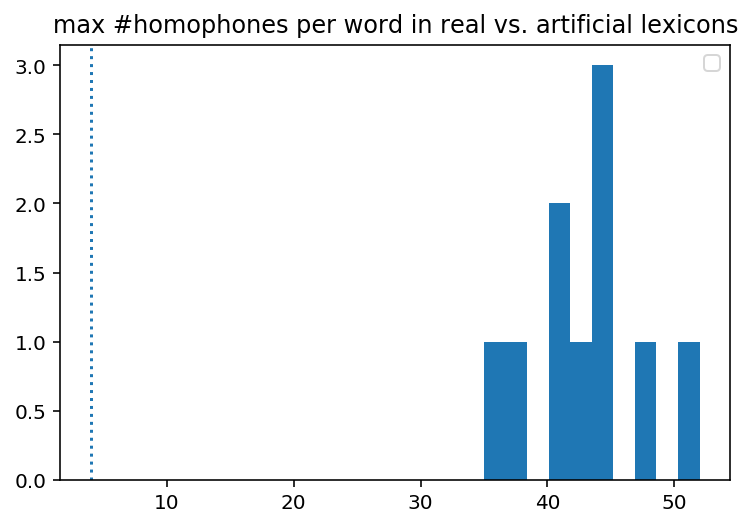

In [44]:
plt.hist(max_homophones)
plt.title("max #homophones per word in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=df_celex_processed['num_homophones'].max(), linestyle="dotted")


##### Distribution of homophones

In [45]:
df_agg_real = utils.agg_homophones_by_syllable(df_celex_processed, 
                                               syl_column='num_sylls_est', 
                                               # syl_column='SylCnt', 
                                               homophone_column='num_homophones')

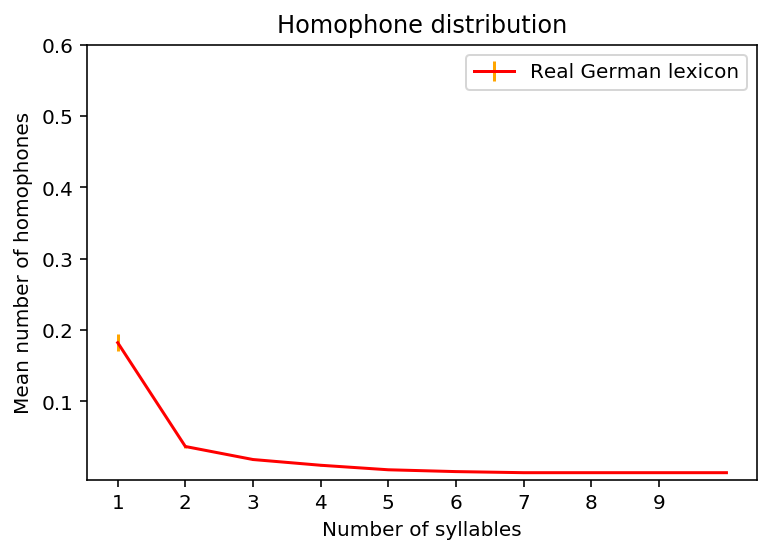

In [46]:
plt.title("Homophone distribution")
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real German lexicon")
plt.xticks(list(range(1, 10)))
plt.yticks([.1, .2, .3, .4, .5, .6])
plt.legend(loc='upper right')

In [47]:
artificials = []
for df_tmp_processed in processed_artificials:
    
    df_agg_art = utils.agg_homophones_by_syllable(df_tmp_processed, 
                                              syl_column='num_sylls_est', 
                                              homophone_column='num_homophones')
    artificials.append(df_agg_art)

df_artificials = pd.concat(artificials)

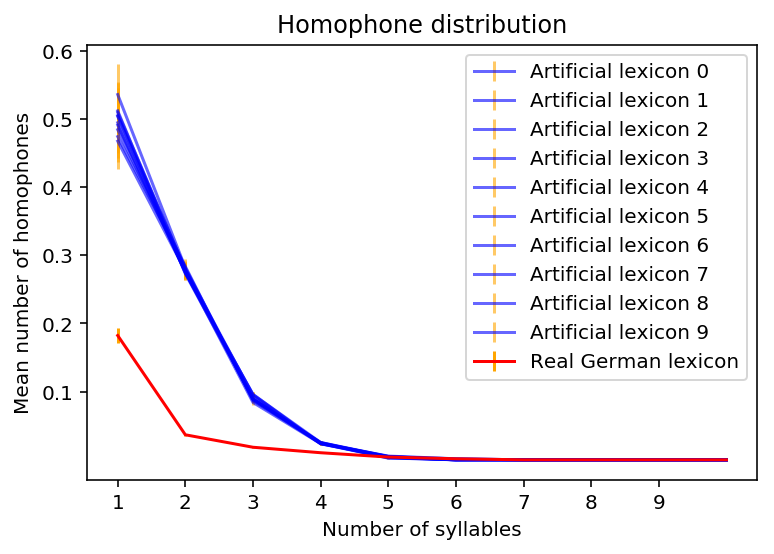

In [48]:
plt.title("Homophone distribution")
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")

for i, df in enumerate(artificials):
    
    plt.errorbar(df['num_sylls'], df['mean_homophones'], alpha = .6,
                        yerr=df['sem_homophones'], color = "blue", ecolor="orange",
                label = "Artificial lexicon {x}".format(x=i))

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real German lexicon")
plt.xticks(list(range(1, 10)))
plt.yticks([.1, .2, .3, .4, .5, .6])
plt.legend(loc='upper right')

### Statistics

As with English, the coefficient on **number of syllables** depends on whether **surprisal** is included. If it is, the real lexicon has a larger magnitude coefficient than the simulated ones; if not, the other way around.

In [49]:
slope_coefs = []
surprisal_coefs_german = []
for df_tmp_processed in tqdm(processed_artificials):    
    # df_tmp = df_tmp[df_tmp['in_celex']==False]
    result = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_tmp_processed).fit(disp=0)
    slope_coefs.append(result.params['num_sylls_est'])
    surprisal_coefs_german.append(result.params['surprisal'])

 40%|████      | 4/10 [00:00<00:00,  7.34it/s]


KeyboardInterrupt: 

In [ ]:
result_real = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_celex_processed).fit(disp=0)
real_slope = round(result_real.params['num_sylls_est'], 2)
surprisal_slope = round(result_real.params['surprisal'], 2)

In [ ]:
plt.hist(slope_coefs)
plt.axvline(x=real_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=real_slope),x=real_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ #syllables")
# plt.legend(loc='upper right')
plt.show()

In [ ]:
plt.hist(surprisal_coefs_german)
plt.axvline(x=surprisal_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(surprisal_slope, 2)),x=surprisal_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ surprisal")
# plt.legend(loc='upper right')
plt.show()

## Dutch

### Real lexicon

In [ ]:
df_celex_og = pd.read_csv("data/processed/dutch/dutch_all_reals.csv")

In [ ]:
len(df_celex_og)

In [ ]:
df_celex_processed = pd.read_csv("data/processed/dutch/dutch_lemmas_processed.csv")
df_celex_processed.head(5)

In [ ]:
len(df_celex_processed)

In [ ]:
REAL_DUTCH_PERCENTAGE = len(df_celex_processed[df_celex_processed['num_homophones']>0]) / len(df_celex_processed)
REAL_DUTCH_PERCENTAGE

### Compare to artificial lexicons

In [ ]:
NUM_ARTIFICIAL = 10

In [ ]:
df_dutch_artificial = pd.read_csv("data/processed/dutch/dutch_artificial_10_matched_on_sylls.csv")


In [ ]:
len(df_dutch_artificial)

In [ ]:
df_dutch_artificial['lexicon'] = df_dutch_artificial['lexicon'].apply(lambda x: str(x))

#### Phonotactics

In [ ]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_dutch_artificial[df_dutch_artificial['lexicon']==str(i)]
    plt.hist(df_tmp['surprisal'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))

plt.hist(df_celex_og['surprisal'], 
         alpha = .7, label = "Real lexicon".format(x=i))
plt.title("Distribution of surprisal estimates")
plt.legend()

#### Length

In [ ]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_dutch_artificial[df_dutch_artificial['lexicon']==str(i)]
    plt.hist(df_tmp['num_sylls_est'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))

plt.hist(df_celex_og['num_sylls_est'], 
         alpha = .9, label = "Real lexicon".format(x=i))
plt.title("Distribution of #syllable estimates")
plt.legend()

## Homophones

### Comparing percentage, mean, and max of homophones

In [ ]:
processed_artificials = []
homophone_percentages = []
mean_homophones, max_homophones = [], []
for i in tqdm(range(NUM_ARTIFICIAL)):
    
    df_tmp = df_dutch_artificial[df_dutch_artificial['lexicon']==str(i)]
    
    df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                      phon_column="word", word_column="word")
    
    homophone_percentages.append(len(df_tmp_processed[df_tmp_processed['num_homophones']>0]) / len(df_tmp_processed))

    mean_homophones.append(df_tmp_processed['num_homophones'].mean())
    max_homophones.append(df_tmp_processed['num_homophones'].max())

    processed_artificials.append(df_tmp_processed)


In [ ]:
plt.hist(homophone_percentages)
plt.title("%homophones in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=REAL_GERMAN_PERCENTAGE, linestyle="dotted")


In [ ]:
plt.hist(mean_homophones)
plt.title("mean #homophones per word in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=df_celex_processed['num_homophones'].mean(), linestyle="dotted")


In [ ]:
plt.hist(max_homophones)
plt.title("max #homophones per word in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=df_celex_processed['num_homophones'].max(), linestyle="dotted")


##### Distribution of homophones

In [ ]:
df_agg_real = utils.agg_homophones_by_syllable(df_celex_processed, 
                                               syl_column='num_sylls_est', 
                                               # syl_column='SylCnt', 
                                               homophone_column='num_homophones')

In [ ]:
plt.title("Homophone distribution")
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real Dutch lexicon")
plt.xticks(list(range(1, 10)))
plt.yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 1.1, 1.2, 1.3])
plt.legend(loc='upper right')

In [ ]:
artificials = []
for df_tmp_processed in processed_artificials:
    
    df_agg_art = utils.agg_homophones_by_syllable(df_tmp_processed, 
                                              syl_column='num_sylls_est', 
                                              homophone_column='num_homophones')
    artificials.append(df_agg_art)

df_artificials = pd.concat(artificials)

In [ ]:
plt.title("Homophone distribution")
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")

for i, df in enumerate(artificials):
    
    plt.errorbar(df['num_sylls'], df['mean_homophones'], alpha = .6,
                        yerr=df['sem_homophones'], color = "blue", ecolor="orange",
                label = "Artificial lexicon {x}".format(x=i))

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real Dutch lexicon")
plt.xticks(list(range(1, 10)))
plt.yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 1.1, 1.2, 1.3])
plt.legend(loc='upper right')

### Statistics

In [ ]:
result_real = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_celex_processed).fit(disp=0)
real_slope = result_real.params['num_sylls_est']
surprisal_slope = result_real.params['surprisal']

In [ ]:
slope_coefs = []
surprisal_coefs_dutch = []
for df_tmp_processed in tqdm(processed_artificials):    
    result = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_tmp_processed).fit(disp=0)
    slope_coefs.append(result.params['num_sylls_est'])
    surprisal_coefs_dutch.append(result.params['surprisal'])

In [ ]:
plt.hist(slope_coefs)
plt.axvline(x=real_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(real_slope, 2)),x=real_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ #syllables")
# plt.legend(loc='upper right')
plt.show()

In [ ]:
plt.hist(surprisal_coefs_dutch)
plt.axvline(x=surprisal_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(surprisal_slope, 2)),x=surprisal_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ surprisal")
# plt.legend(loc='upper right')
plt.show()

## French

### Real lexicon

In [ ]:
df_celex_og = pd.read_csv("data/processed/french/french_all_reals.csv")

In [ ]:
df_celex_og = pd.read_csv("data/processed/french/french_all_reals.csv")

In [ ]:
len(df_celex_og)

In [ ]:
df_celex_processed = pd.read_csv("data/processed/french/french_lemmas_processed.csv")
df_celex_processed.head(5)

In [ ]:
len(df_celex_processed)

In [ ]:
REAL_FRENCH_PERCENTAGE = len(df_celex_processed[df_celex_processed['num_homophones']>0]) / len(df_celex_processed)
REAL_FRENCH_PERCENTAGE

In [ ]:
import numpy as np

In [ ]:
s = df_celex_og[pd.notnull(df_celex_og['2_phon'])]

In [ ]:
len(s)

### Compare to artificial lexicons

In [ ]:
NUM_ARTIFICIAL = 10

In [ ]:
df_french_artificial = pd.read_csv("data/processed/french/french_artificial_10_matched_on_sylls.csv")


In [ ]:
len(df_french_artificial)

In [ ]:
df_french_artificial['lexicon'] = df_french_artificial['lexicon'].apply(lambda x: str(x))

#### Phonotactics

In [ ]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_french_artificial[df_french_artificial['lexicon']==str(i)]
    plt.hist(df_tmp['surprisal'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))

plt.hist(df_celex_og['surprisal'], 
         alpha = .7, label = "Real lexicon".format(x=i))
plt.title("Distribution of surprisal estimates")
plt.legend()

#### Length

In [ ]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_french_artificial[df_french_artificial['lexicon']==str(i)]
    plt.hist(df_tmp['num_sylls_est'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))

plt.hist(df_celex_og['num_sylls_est'], 
         alpha = .9, label = "Real lexicon".format(x=i))
plt.title("Distribution of #syllable estimates")
plt.legend()

## Homophones

### Comparing percentage, mean, and max of homophones

In [ ]:
processed_artificials = []
homophone_percentages = []
mean_homophones, max_homophones = [], []
for i in tqdm(range(NUM_ARTIFICIAL)):
    
    df_tmp = df_french_artificial[df_french_artificial['lexicon']==str(i)]
    
    df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                      phon_column="word", word_column="word")
    
    homophone_percentages.append(len(df_tmp_processed[df_tmp_processed['num_homophones']>0]) / len(df_tmp_processed))

    mean_homophones.append(df_tmp_processed['num_homophones'].mean())
    max_homophones.append(df_tmp_processed['num_homophones'].max())

    processed_artificials.append(df_tmp_processed)


In [ ]:
plt.hist(homophone_percentages)
plt.title("%homophones in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=REAL_FRENCH_PERCENTAGE, linestyle="dotted")


In [ ]:
plt.hist(mean_homophones)
plt.title("mean #homophones per word in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=df_celex_processed['num_homophones'].mean(), linestyle="dotted")


In [ ]:
plt.hist(max_homophones)
plt.title("max #homophones per word in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=df_celex_processed['num_homophones'].max(), linestyle="dotted")


##### Distribution of homophones

In [ ]:
df_agg_real = utils.agg_homophones_by_syllable(df_celex_processed, 
                                               syl_column='num_sylls_est', 
                                               # syl_column='SylCnt', 
                                               homophone_column='num_homophones')

In [ ]:
plt.title("Homophone distribution")
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real French lexicon")
plt.xticks(list(range(1, 10)))
plt.yticks([.2, .4, .6, .8, 1, 1.2])
plt.legend(loc='upper right')

In [ ]:
artificials = []
for df_tmp_processed in processed_artificials:
    
    df_agg_art = utils.agg_homophones_by_syllable(df_tmp_processed, 
                                              syl_column='num_sylls_est', 
                                              homophone_column='num_homophones')
    artificials.append(df_agg_art)

df_artificials = pd.concat(artificials)

In [ ]:
plt.title("Homophone distribution")
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")

for i, df in enumerate(artificials):
    
    plt.errorbar(df['num_sylls'], df['mean_homophones'], alpha = .6,
                        yerr=df['sem_homophones'], color = "blue", ecolor="orange",
                label = "Artificial lexicon {x}".format(x=i))

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real French lexicon")
plt.xticks(list(range(1, 10)))
plt.yticks([.2, .4, .6, .8, 1, 1.2])
plt.legend(loc='upper right')

### Statistics

In [ ]:
result_real = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_celex_processed).fit(disp=0)
real_slope = result_real.params['num_sylls_est']
surprisal_slope = result_real.params['surprisal']

In [ ]:
slope_coefs = []
surprisal_coefs_french = []
for df_tmp_processed in tqdm(processed_artificials):    
    result = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_tmp_processed).fit(disp=0)
    slope_coefs.append(result.params['num_sylls_est'])
    surprisal_coefs_french.append(result.params['surprisal'])

In [ ]:
plt.hist(slope_coefs)
plt.axvline(x=real_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(real_slope, 2)),x=real_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ #syllables")
# plt.legend(loc='upper right')
plt.show()

In [ ]:
plt.hist(surprisal_coefs_french)
plt.axvline(x=surprisal_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(surprisal_slope, 2)),x=surprisal_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ surprisal")
# plt.legend(loc='upper right')
plt.show()